# Convolutional Neural Networks for classification

-- Prof. Dorien Herremans & Jan Melechovsky

We will be demonstrating the use of CNNs for image classification. This tutorial will use PyTorch, which all of you should be familiar with at this point. 

Since training CNNs goes significantly faster on a GPU, please change your runtime to GPU. It will make things about 10x faster. You change this using the Runtime menu（change runtime type）in Google Colab or use the student GPU cluster at SUTD. 

At the moment there are three popular libaries for machine learning in Python: 
- Pytorch: a very powerful and customizable tool, getting more and more popular each day, good for researchers.
- TensorFlow: Google's library. Has a reputation of being un-userfriendly as the API changes all the time and it is quite unintuitive. Also gives the user less control. Wyth version 3.0 some user-friendlyness and Keras-like interface was introduced. 
- Keras: a high level front end for Tensorflow. Very user friendly and simple to use. This is basically in the process of being merged into TensorFlow. 

Side note: you may have heard of Theano, which is an older tool that used to be very popular with researchers. It has gotten less and less popular the last few years. 

Fast.ai on the other hand is getting more traction the last few years. This is another high-level library. 

In [1]:
# If PyTorch is not installed, please do so with the command(s) below, should be ok in Colab: 
!pip install torch
!pip install torchvision

## Why GPUs? 
Is it really so important to use GPU versus CPU for matric calculations? Let's examine. First of all, let's double check that a GPU (cuda) is detected in your runtime: 

In [2]:
import torch

print("PyTorch version:")
print(torch.__version__)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))


PyTorch version:
1.10.0+cu111
Using cuda device


Now that you know the name of your GPU device, we can do a matrix multiplication specifically on this device. Let's try something simple like $X \times X^t$. We will fill the matrix $X$ with random numbers and it will have dimensions $n=3000$).

In [3]:
n = 3000
x = torch.rand(n,n)
print(x.shape)
print(x.dtype)

torch.Size([3000, 3000])
torch.float32


Let's do a simple matrix multiplicaton using the **C**PU and register the time it takes to execute: 

In [4]:
import time
start_time = time.time()

x.matmul(x.t())

print ('The elapsed time is {}'.format(time.time()-start_time) +' seconds.') #print the elapsed time

The elapsed time is 0.8545234203338623 seconds.


Now let's use our GPU to perform the same multiplication:

In [5]:
x=x.to(device) #send our tensor to GPU, this does take time when executing for the first time

print(x.device) #check that this says cuda

start_time = time.time()
x.matmul(x.t())

print ('The elapsed time is {}'.format(time.time()-start_time) +' seconds.')

cuda:0
The elapsed time is 0.11399412155151367 seconds.


So much faster!

Leveraging the GPU for matrix operations is so important in CNNs due to the convolution operation, which is in essence a matrix multiplication. So let's have a look how convolution speeds up. We will be using PyTorch to do a 2D convolution with a $32\times7\times7\times3$ filter for 100 images with random pixels ($100\times100$ with 3 channels).

We can use the exact same Conv2D function for these two tests, except, we use  another device. We can do this by using .to(device) function, where our device='cuda' or 'cpu'. To make it easy, we define two functions for this: cpu_conv and gpu_conv. We also demonstrate a slightly different way to time operations using the `timeit` library.


In [6]:
import torch.nn as nn
import timeit

# function to generate random image and run convolution on CPU
def cpu_conv():
    random_image_cpu = torch.randn(100, 3, 100, 100) # 100 images (batch size), 3 channels, 100x100 height and width -> [B,C,H,W]
    cpuconv2=nn.Conv2d(3, 32, 7) #3 input channels, 32 output channels (number of filters), 7 kernel size (7x7 width and height)
    cpuout=cpuconv2(random_image_cpu)
    return cpuout

# function to generate random image, move it to GPU device, run convolution on GPU
def gpu_conv():
    random_image_gpu = torch.randn(100, 3, 100, 100).to(device) # 100 images (batch size), 3 channels, 100x100 height and width
    gpuconv2=nn.Conv2d(3, 32, 7).to(device)
    gpuout=gpuconv2(random_image_gpu)
    return gpuout

# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu_conv()
gpu_conv()

# Run the functions several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x channel x height x width). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu_conv()', number=10, setup="from __main__ import cpu_conv")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu_conv()', number=10, setup="from __main__ import gpu_conv")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x channel x height x width). Sum of ten runs.
CPU (s):
1.8310491490000231
GPU (s):
0.2929290900000012
GPU speedup over CPU: 6x


Notice, that the speed is only about 6x higher. Now, instead of initialising  (creating) the tensors and conv layers in each run, we initialise them once and only evaluate the convolution operation speed. This is a bit more realistic, since we usually have both our data and our model on the GPU already... ready? 

In [7]:
import torch.nn as nn
import timeit

# apply the Conv2d function (clayer) to a tensor
def convolution(clayer,tensor):
    out=clayer(tensor)
    return out

# create the image and do normal conv2d on CPU
random_image_cpu = torch.randn(100, 3, 100, 100) # 100 images (batch size), 3 channels, 100x100 heigth and width -> [B,C,H,W]
cpuconv2=nn.Conv2d(3, 32, 7) #3 input channels, 32 output channels (number of filters), 7 kernel size (7x7 width and height)

# create the image, move to GPU (.to(device)) and do conv2d on GPU
random_image_gpu = torch.randn(100, 3, 100, 100).to(device) # here we make a tensor of the same size, but push it to our cuda device
gpuconv2=nn.Conv2d(3, 32, 7).to(device) # again, we push our convolutional layer to gpu

# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
convolution(cpuconv2,random_image_cpu)
convolution(gpuconv2,random_image_gpu)

# Run the functions several times and time them using timeit.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x channel x height x width). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('convolution(cpuconv2,random_image_cpu)', number=10, setup="from __main__ import convolution, cpuconv2, random_image_cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('convolution(gpuconv2,random_image_gpu)', number=10, setup="from __main__ import convolution, gpuconv2, random_image_gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x channel x height x width). Sum of ten runs.
CPU (s):
1.5805086219999964
GPU (s):
0.002617529999980661
GPU speedup over CPU: 603x


So fast sia!

Why do we show you the slow as well as the fast version? To make you extra aware that data transfer is slow. My computer science teacher used to say: a computer is only as fast as its cables can transit data. This principe is demonstrated here. Once the tensors are on the GPU, operations are lightening fast, but loading them onto the GPU takes valuable time. (Which is still faster than CPU operation though!)

Ok, so now that we see why we need to use GPUs (and why image processing has advanced so much after the invention of both CNNs and GPUs), let's move on the an actual example of image classification. 

## Cats versus Dogs 
We will be performing a 2-class classification problem: classifying dogs versus cats from images. Our dataset is based on the Kaggle dataset https://www.kaggle.com/c/dogs-vs-cats/data. Do **not** use this dataset, however, as it is very big and will take too long to train. 

**Please download the reduced dataset from dorienherremans.com/drop -> cds / cnns/ catsanddogs. This reduced dataset contains 1,000 training examples for each class, and 400 validation examples for each class.

In summary, this is our directory structure:
```
data/
    train/
        dogs/
            dog001.jpg
            dog002.jpg
            ...
        cats/
            cat001.jpg
            cat002.jpg
            ...
    validation/
        dogs/
            dog001.jpg
            dog002.jpg
            ...
        cats/
            cat001.jpg
            cat002.jpg
            ...
preview/
```


Notice how the labels of the images are, in fact, the folders. You can use any other types of labels/images to train this model and it will adapt accordingly...


Start by loading the necessary libraries for the lab: 

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from torchsummary import summary
import torch.nn as nn

Download the reduced dataset: 

In [9]:
!wget -P / -c --no-check-certificate "https://dorienherremans.com/drop/CDS/CNNs/cat_dog.zip"

--2021-11-26 08:35:18--  https://dorienherremans.com/drop/CDS/CNNs/cat_dog.zip
Resolving dorienherremans.com (dorienherremans.com)... 99.198.97.250
Connecting to dorienherremans.com (dorienherremans.com)|99.198.97.250|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64180857 (61M) [application/zip]
Saving to: ‘cat_dog.zip’

at_dog.zip          100%[===================>]  61.21M  94.9MB/s    in 0.6s    

2021-11-26 08:35:19 (94.9 MB/s) - ‘cat_dog.zip’ saved [64180857/64180857]



Unzip the file you just downloaded. This will extract everything in the folder structure described above. 


In [10]:
import zipfile
zip_ref = zipfile.ZipFile('./cat_dog.zip', 'r')
zip_ref.extractall('./')
zip_ref.close()

Next, we'll store the training and validation data path in two variables. We'll also store the image resolution in two variables and create a tensor of the right input dimensions, which we can will use later: 

In [11]:
img_height, img_width = 150, 150
input_shape=torch.Tensor((img_height, img_width))
train_data_dir = 'data/train'
validation_data_dir = 'data/validation'

classes = ('cat','dog')

# Simple CNN

Let's preprocess the images before we feed them into the CNN. We will use the functions called `dataloaders` and `datasets` to load batches of images and feed them into the network. 

We will also explore how we can use the `transforms` function to adapt images as they are loaded. 

Our images should all be of a fixed input size, we chose $150\times150$px size. There are multiple ways of achieving that. Here, we scale down the images so that their smallest edge is 150px. The other edge is then center-cropped to 150px. Alternatively, we could have used `Resize(150,150)`, which will not only scale down the image, but also squeeze one of its axes which deforms the image.

Final step is transforming the image into a PyTorch tensor. This step also normalises the data to be in the range `[0,1]`, rather than the original `[0,255]`. Neural networks always work better when the input data is normalized. 

Then, we load the dataset using the `ImageFolder` command, which tells us that the classification label equals the name of the folder in which the image is stored. This is extremely useful and makes it easy to load image data properly for any classification task. 

In [12]:
# Resize the image and do a center crop, and store them on a tensor
transform = transforms.Compose([transforms.Resize(img_height),transforms.CenterCrop(img_width), transforms.ToTensor()])

# Load the training and validation dataset
train_dataset = datasets.ImageFolder(train_data_dir, transform=transform)
val_dataset = datasets.ImageFolder(validation_data_dir, transform=transform)

Next, we want to define our dataloaders, which we will use to retrieve batches of data from our dataset. Dataloaders are essential. They speed up data loading and allow you do things like stratified sampling in case your dataset is not balanced. 

In [13]:
batch_size = 30
train_dataloader = DataLoader(train_dataset, batch_size=batch_size,shuffle=True,num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size,num_workers=2)

Let's try loading an image using the our new dataloader and have a look at it.


This is a dog.


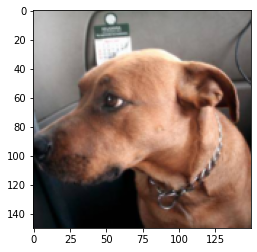

In [14]:
images,labels = next(iter(train_dataloader))
print('This is a {}.'.format(classes[labels[0]]))
plt.imshow(images[0].moveaxis(0,2))

We can utilise `make_grid` from `torchvision.utils` to plot the whole batch. Execute the next cell a couple of times and see for yourself!

       cat        dog        cat        dog


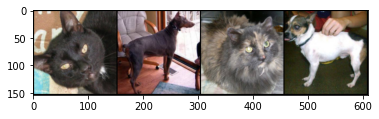

In [15]:
number_of_pics = 4
images,labels = next(iter(train_dataloader)) #load in a batch of data with the dataloader
imagegrid = torchvision.utils.make_grid(images[0:number_of_pics,:,:,:]) #join the images from the batch into one grid
print(' '.join('%10s' % classes[labels[j]] for j in range(number_of_pics)))
plt.imshow(imagegrid.moveaxis(0,2))
plt.show()

### Model architecture
Now we are ready to define our model architecture. We'll use a three layered convolutional network with ReLu units and pooling. On top of the three convolutional layers, we will add two fully-connected layers. For that, we need to calculate the output size of the convolutional part to properly initialise the fully-connected part.

In [16]:
def calcsize(model,channum,imh,imw):
  image=torch.rand(channum,imh,imw)
  image=image[None,:]
  output=model(image)
  return output.shape[1:]

#initialise our model
model=nn.Sequential(nn.Conv2d(3, 32, 3),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),
        nn.Conv2d(32, 32, 3),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),
        nn.Conv2d(32, 64, 3),
        nn.ReLU(),
        nn.MaxPool2d(2, 2)
        )

channum=3 # number of colour channels - RGB=3

output_size=calcsize(model,channum,img_height,img_width)
print(output_size)

# Now that you know the output size you can extend the model with the last fully connected layers
layers = list(model.children())
layers.extend([nn.Flatten(),
                 nn.Linear(output_size[0]*output_size[1]*output_size[2], 64),
                 nn.Dropout(0.5),
                 nn.Linear(64,1),
                 nn.Sigmoid()
                 ])

# move the model on the GPU
model=nn.Sequential(*layers).to(device)

torch.Size([64, 17, 17])


We initialise the model on our GPU device, choose RMSprop optimizer and use a Binary Cross-Entropy Loss function (`BCELoss`) as we are classfying between two classes. We can use `torch.summary` to print a nice overview of our model. The overview tells us the output shape at each layer as well as the number of parameters (weights/filters) the model needs to optimize. 

In [17]:
# Set optimizer and loss function (criterion)
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.0001)
criterion = torch.nn.BCELoss()

# Print summary
summary(model,(3,img_height,img_width)) # using torchsummary

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 148, 148]             896
              ReLU-2         [-1, 32, 148, 148]               0
         MaxPool2d-3           [-1, 32, 74, 74]               0
            Conv2d-4           [-1, 32, 72, 72]           9,248
              ReLU-5           [-1, 32, 72, 72]               0
         MaxPool2d-6           [-1, 32, 36, 36]               0
            Conv2d-7           [-1, 64, 34, 34]          18,496
              ReLU-8           [-1, 64, 34, 34]               0
         MaxPool2d-9           [-1, 64, 17, 17]               0
          Flatten-10                [-1, 18496]               0
           Linear-11                   [-1, 64]       1,183,808
          Dropout-12                   [-1, 64]               0
           Linear-13                    [-1, 1]              65
          Sigmoid-14                   

Then we define our training and evaluation loop.

In [18]:
import time


# Train the model
def train(model,dataloader,val_dataloader):
    model.train() #set the mode of the model to train mode
    total_acc, total_count, rep_acc, rep_count = 0, 0, 0, 0
    train_loss, rep_loss=0.0, 0.0
    log_interval = 50
    start_time = time.time() # time the training

    for i, data in enumerate(dataloader):
        inputs, labels = data
        # make sure the data is on the GPU
        labels=labels.reshape(labels.shape[0],1).float().to(device)
        inputs=inputs.to(device)     
        optimizer.zero_grad()

        # forward propagation, i.e. get predictions
        predicted_label = model(inputs)

        # calculate loss and backpropagate to model paramters:
        loss = criterion(predicted_label, labels)
        train_loss += loss.item() # to be reported per epoch
        rep_loss += loss.item() # to be reported per log_interval batches
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)

        # update parameters by stepping the optimizer
        optimizer.step()

        # update the total accuracy to be reported per epoch and batch, and keep track of the loop 
        total_acc += ((predicted_label > 0.5) == labels).sum().item() # to be reported per epoch
        rep_acc += ((predicted_label > 0.5) == labels).sum().item() # to be reported per log_interval batches
        total_count += labels.size(0)
        rep_count += labels.size(0)

        if i % log_interval == 0 and i > 0:
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches '
                  '| train_loss {:8.3f} | accuracy {:8.3f} | elapsed time {:5.1f} seconds'.format(epoch, i, len(dataloader),
                                              rep_loss/log_interval, rep_acc/rep_count, elapsed))
            rep_acc, rep_count = 0, 0
            rep_loss=0.0
            start_time = time.time()


    # Make a pass over the validation data.
    val_acc, val_count = 0.0, 0.0
    cum_loss = 0.0
    model.eval()
    with torch.no_grad():
        for j, data in enumerate(val_dataloader):
            inputs, labels = data
            labels=labels.reshape(labels.shape[0],1).float().to(device)
            inputs=inputs.to(device)

            # Forward pass. (Prediction stage)
            scores = model(inputs)
            cum_loss += criterion(scores, labels).item()

            # Count how many correct in this batch.
            val_acc += ((scores > 0.5) == labels).sum().item()
            val_count += labels.size(0)


    # Logging the current results on validation.
    print('Validation-epoch %d. Avg-Val.Loss: %.4f, Val. Accuracy: %.4f' % 
            (epoch, cum_loss / (j + 1), val_acc/val_count))
    return total_acc/total_count, val_acc/val_count, train_loss/(i+1), cum_loss / (j + 1)
      

### Training

Now that we defined our evaluation and training functions, let's do the actual training. I recommend as many epochs as your computer can handle, but put it to very few the first time you run. (It can be time consuming: about 1-60 seconds an epoch, so definitely use GPU!)

We are storing loss and accuracy parameters here so that we can plot them later.

In [19]:
ta=[]
va=[]
tl=[]
vl=[]
for epoch in range(30):
  train_acc, val_acc, train_loss, val_loss=train(model,train_dataloader,val_dataloader)
  ta.append(train_acc)
  va.append(val_acc)
  tl.append(train_loss)
  vl.append(val_loss)

| epoch   0 |    50/   67 batches | train_loss    0.702 | accuracy    0.536 | elapsed time   6.7 seconds
Validation-epoch 0. Avg-Val.Loss: 0.6652, Val. Accuracy: 0.5950
| epoch   1 |    50/   67 batches | train_loss    0.674 | accuracy    0.608 | elapsed time   6.3 seconds
Validation-epoch 1. Avg-Val.Loss: 0.6426, Val. Accuracy: 0.6375
| epoch   2 |    50/   67 batches | train_loss    0.655 | accuracy    0.639 | elapsed time   6.4 seconds
Validation-epoch 2. Avg-Val.Loss: 0.6345, Val. Accuracy: 0.6325
| epoch   3 |    50/   67 batches | train_loss    0.637 | accuracy    0.648 | elapsed time   6.6 seconds
Validation-epoch 3. Avg-Val.Loss: 0.6361, Val. Accuracy: 0.6225
| epoch   4 |    50/   67 batches | train_loss    0.629 | accuracy    0.663 | elapsed time   6.6 seconds
Validation-epoch 4. Avg-Val.Loss: 0.6056, Val. Accuracy: 0.7000
| epoch   5 |    50/   67 batches | train_loss    0.618 | accuracy    0.680 | elapsed time   6.7 seconds
Validation-epoch 5. Avg-Val.Loss: 0.5937, Val. Acc

The model is a little unstable, with accuracy varying around 69-72%, not a bad result for a small model with little data! 

After this wait you will want to save your weights, so that you can reuse your model without training it again. Let's take a look at what the weights look like:

In [20]:
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

#save the parameters of a model
torch.save(model.state_dict(), 'mymodel.pt')

Model's state_dict:
0.weight 	 torch.Size([32, 3, 3, 3])
0.bias 	 torch.Size([32])
3.weight 	 torch.Size([32, 32, 3, 3])
3.bias 	 torch.Size([32])
6.weight 	 torch.Size([64, 32, 3, 3])
6.bias 	 torch.Size([64])
10.weight 	 torch.Size([64, 18496])
10.bias 	 torch.Size([64])
12.weight 	 torch.Size([1, 64])
12.bias 	 torch.Size([1])


If we want to load our model, we can do so by initialising the model architecture first, and then load the saved weights into it.

In [21]:
def mymodel(input_shape):  
  #initialise our model
  model=nn.Sequential(nn.Conv2d(3, 32, 3),
          nn.ReLU(),
          nn.MaxPool2d(2, 2),
          nn.Conv2d(32, 32, 3),
          nn.ReLU(),
          nn.MaxPool2d(2, 2),
          nn.Conv2d(32, 64, 3),
          nn.ReLU(),
          nn.MaxPool2d(2, 2)
          )

  channum=3 # number of colour channels - RGB=3
  img_height = int(input_shape.numpy()[0])
  img_width = int(input_shape.numpy()[1])
  output_size=calcsize(model,channum,img_height,img_width)
  print(output_size)

  # Now that you know the output size you can extend the model with the last fully connected layers
  layers = list(model.children())
  layers.extend([nn.Flatten(),
                  nn.Linear(output_size[0]*output_size[1]*output_size[2], 64),
                  nn.Dropout(0.5),
                  nn.Linear(64,1),
                  nn.Sigmoid()
                  ])

  # move the model on the GPU
  model=nn.Sequential(*layers)
  return model

In [25]:
#create a new model of the same architecture! and load the parameter values
model2 = mymodel(input_shape).to(device)
model2.load_state_dict(torch.load('mymodel.pt'))
model2.eval()      #turning it to evaluation mode (train mode is the default option when the model is created)

torch.Size([64, 17, 17])


Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Flatten(start_dim=1, end_dim=-1)
  (10): Linear(in_features=18496, out_features=64, bias=True)
  (11): Dropout(p=0.5, inplace=False)
  (12): Linear(in_features=64, out_features=1, bias=True)
  (13): Sigmoid()
)

### Evaluating the model during training

Let's now take a look at how the training went graphically!

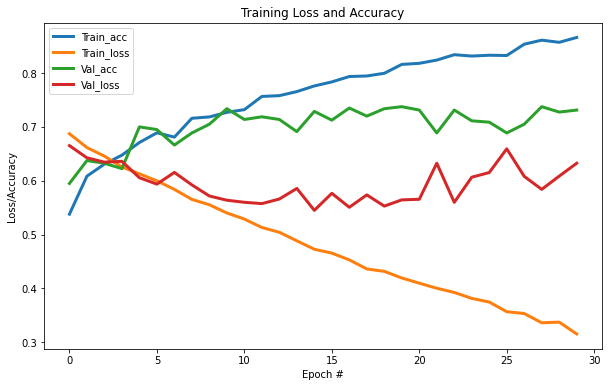

In [26]:
def plotResults(): 
    plt.figure(figsize=(10,6))
    epovec=range(len(ta))
    plt.plot(epovec,ta,epovec,tl,epovec,va,epovec,vl,linewidth=3)
    plt.legend(('Train_acc','Train_loss','Val_acc','Val_loss'))

    # make the graph understandable: 
    plt.title("Training Loss and Accuracy")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.show()
    
plotResults()


After ~30 epochs the neural network reaches ~70% accuracy. We can witness overfitting, as not much progress is made on the validation set in the next epochs, in fact, the validation loss goes up after about 20 epochs. 

# Augmented data model

Overfitting can possibly be remedied by augmenting our dataset so that our model becomes more robust. Let's take a random image of a cat again and display it: 


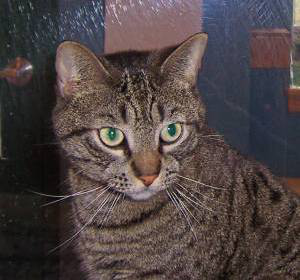

In [27]:
from PIL import Image
  
# open method used to open different extension image file
img = Image.open(r'./data/train/cats/cat.1.jpg') 
  
# This method will show image in any image viewer
img

She's cute and looks like my cat [Sendai](https://www.facebook.com/Sendai-251531448370007/) (who is sadly still in Belgium). Unlike Sendai, who likes posing for the camera, we only have one shot of this cat. So let's augment this image into multiple slightly different images...

The Torchvision [`transforms` library](https://pytorch.org/vision/stable/transforms.html) can help us perform data augmentation. This means that we can perform a series of alterations to the image such as the below:  

`transforms.RandomAffine` contains a number of transformations:
* rotation by a random degrees value from a range.
* translation of the picture by a random amount (vertical, horizontal).
* shear transformation (skewing the picture) in a range.
* and many more...

Other functions include:
* `transforms.RandomHorizontalFlip` for randomly flipping half of the images horizontally --relevant when there are no assumptions of horizontal assymetry (e.g. real-world pictures).
* `transforms.RandomCrop` simply crops out a frame of predefined size from the picture at random position.
* `transforms.RandomResizedCrop` crops out a frame while also rescaling the image and changing the pixel ratio of the crop.

For more information, check out the [documentation](https://pytorch.org/vision/stable/transforms.html). 

Let's test this out on the cat image: 

In [28]:
img = Image.open(r'./data/train/cats/cat.1.jpg') 
import glob
augtransforms=transforms.Compose([transforms.Resize((150,150)),
transforms.RandomAffine(degrees=(-30,30),translate=(0.1,0.1),shear=(-10,10)),
transforms.RandomResizedCrop((150,150),scale=(0.8,1),ratio=(0.9,1.1)),
transforms.RandomHorizontalFlip()])
#transforms.RandomRotation(degrees=(-40,40))])
#there's no ToTensor transformation here, we will first just use this to create .jpg images and save them for demo purposes

#you can try more transforms such as these:
#transforms.RandomCrop(150)


for i in range(10):
  newimg=augtransforms(img)
  newimg.save('preview/augcat'+str(i)+'.jpg')

This has generated new and transformed images in our preview/ folder. You can check in your filemanager or via: 

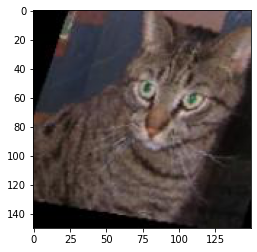

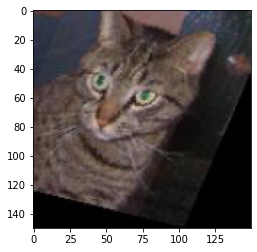

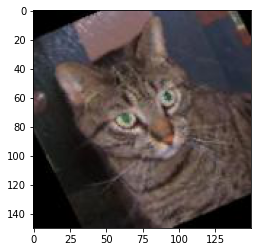

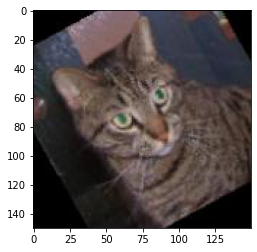

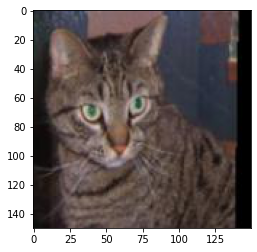

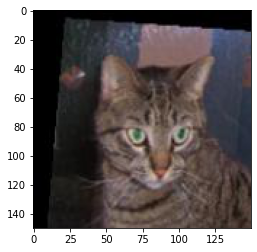

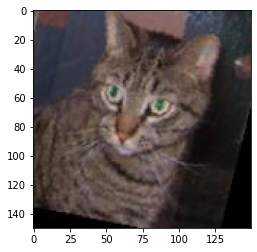

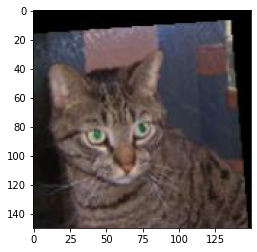

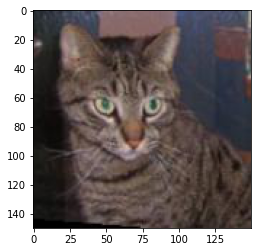

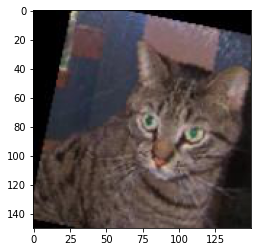

In [29]:
from PIL import Image
import glob
for filename in glob.glob('preview/*.jpg'): 
    img=Image.open(filename)
    imgplot = plt.imshow(img)
    plt.show()

Great! Notice how the cat images are mirrored, skewed and generally deformed. This will allow our model to train more robustly. 

Now it's time to fit the new data into our model. Again, we will be downscaling all the images to $150\times150$ pixels so that they are all the same size. We will use the same 3-layered model with ReLu nodes and pooling that was previously defined, but initialise it again.

Now we can integrate this in our previous data preprocessing as follows: 

In [30]:
augtransforms=transforms.Compose([transforms.Resize((150,150)),
transforms.RandomAffine(degrees=(-25,25),translate=(0.1,0.1),shear=(-7,7)),
transforms.RandomResizedCrop((150,150),scale=(0.8,1),ratio=(0.9,1.1)),
transforms.RandomHorizontalFlip(),
transforms.ToTensor()]) # don't forget to add ToTensor when using the DataLoader

batch_size = 30
augtrain_dataset = datasets.ImageFolder(train_data_dir, transform=augtransforms) # our new augmented dataset
augtrain_dataloader = DataLoader(augtrain_dataset, batch_size=batch_size,shuffle=True,num_workers=2) #and our new dataloader for this set

val_dataloader = DataLoader(val_dataset, batch_size=batch_size,num_workers=2)

Now we define a new model `augmodel` with the exact same architecture as before. We set the same optimizer and loss function as well. 

In [31]:
augmodel = nn.Sequential(*layers).to(device) # set the model to be the same model as before, but with weights reinitilized
optimizer = torch.optim.RMSprop(augmodel.parameters(), lr=0.0001)
criterion = torch.nn.BCELoss()

Then we can train the model again. Note, I put 30 epochs, this may take a while, so adjust as necessary. 

In [32]:
ta=[]
va=[]
tl=[]
vl=[]
for epoch in range(30):
  train_acc, val_acc, train_loss, val_loss=train(augmodel,augtrain_dataloader,val_dataloader)
  ta.append(train_acc)
  va.append(val_acc)
  tl.append(train_loss)
  vl.append(val_loss)

| epoch   0 |    50/   67 batches | train_loss    0.764 | accuracy    0.682 | elapsed time   8.0 seconds
Validation-epoch 0. Avg-Val.Loss: 0.5543, Val. Accuracy: 0.7163
| epoch   1 |    50/   67 batches | train_loss    0.563 | accuracy    0.728 | elapsed time   8.1 seconds
Validation-epoch 1. Avg-Val.Loss: 0.5433, Val. Accuracy: 0.7375
| epoch   2 |    50/   67 batches | train_loss    0.564 | accuracy    0.718 | elapsed time   7.9 seconds
Validation-epoch 2. Avg-Val.Loss: 0.5307, Val. Accuracy: 0.7300
| epoch   3 |    50/   67 batches | train_loss    0.550 | accuracy    0.724 | elapsed time   7.8 seconds
Validation-epoch 3. Avg-Val.Loss: 0.5235, Val. Accuracy: 0.7388
| epoch   4 |    50/   67 batches | train_loss    0.550 | accuracy    0.733 | elapsed time   7.9 seconds
Validation-epoch 4. Avg-Val.Loss: 0.5299, Val. Accuracy: 0.7250
| epoch   5 |    50/   67 batches | train_loss    0.541 | accuracy    0.742 | elapsed time   8.0 seconds
Validation-epoch 5. Avg-Val.Loss: 0.5273, Val. Acc

Let's visualise the loss and validation during the training: 

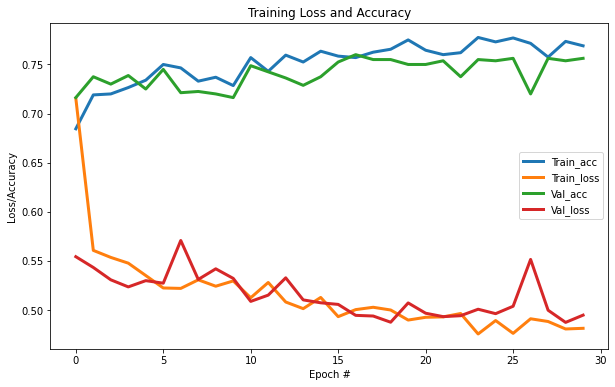

In [33]:
plotResults()

The model is no longer overfitting and, considering the small dataset, reaches an impressive accuracy! 



Now let's see if we can use this model to get the class prediction for one particular image: 

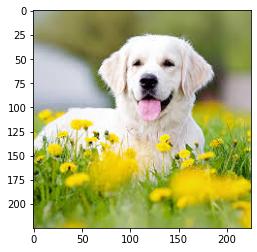

In [34]:
# Is this a dog or a cat? 
img = Image.open(r'./data/test/test.jpg') 
imgplot = plt.imshow(img)
plt.show()

Now let's predict the class this image belongs to: 

In [35]:
testimg = Image.open(r'./data/test/test.jpg') 
testimg = transform(testimg)
testimg=testimg[None,:].to(device) #trick to add one more dimension (batch dimension)

augmodel.eval()
with torch.no_grad():
  pred_prob=augmodel(testimg)
  pred_class=(pred_prob > 0.5)

if pred_class == 1:
    prediction = 'dog'
    print("This image is a "+ prediction + ".")
    print('With probability of  ' + str(pred_prob.item()))
else:
    prediction = 'cat'
    print("This image is a "+ prediction + ".")
    print('With probability of  ' + str(1-pred_prob.item()))

This image is a dog.
With probability of  0.9995611310005188


It worked! Do you have a picture of your pet? Give it a go and see if your model can predict what it is!

Note: if you did not train your model very long, it won't be accurate. For real applications, you may want to try a pretrained model (see below). 

# Advanced pretrained model 
Researchers and companies like Google have built some very accurate image recognition models that were trained on a lot of data. Using these will often improve your results: if you start from a saved pretrained model and further finetune this using your data, you get a head start! The below code is meant as an example of how you may do this. There are many different pretrained models out there. Find one that is right for your data... 

We use the pretrained model on ImageNet data which is available at https://gist.github.com/baraldilorenzo/07d7802847aaad0a35d3 (no need to download, the script will automatically fetch the data for you). The module architecture of the model (VGG) we are loading is as follows: 
![alt text](https://blog.keras.io/img/imgclf/vgg16_modified.png "Title")


The VGG16 model is available in `torchvision`. There are many more modules available, as you can see in the documentation: https://pytorch.org/vision/stable/models.html

Let's load VGG it and take a look at it. 

In [36]:
import torchvision.models as models
import torch.nn as nn
model_vgg=models.vgg16(pretrained=True).to(device) #import the vgg16 model
#model_vgg=models.vgg16_bn(pretrained=True) #FYI this model is enhanced with Batch_normalization layers
print(model_vgg) #Let's look at the model

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

We can see that the model is divided into 3 parts - 'features', 'avgpool', and 'classifier'. We will use the pretrained model as a feature representation, and just edit and fine-tune the classifier part.

We have **two** options now. Either we replace the last layer of the classifier to fit our number of classes, or we can replace the whole classifier with our own (simpler approach, with less training time). We will show both options below... 



## Option 1: Replace last layer of classifier (optional, you may skip to option 2 for the easier option)


### Adjust the model

We delete the last layer here and replace is by one that is of the right size to fit our number of classes. 

In [37]:
#we can freeze the weights by disabling gradient for the parameters, it should not be necessary in our case, since we do not plan to train the whole model, but FYI
for param in model_vgg.features.parameters(): #disabling gradient in the 'features' part of the model (convolutional part)
    param.require_grad = False #tell the model to keep the weights fixed

num_features = model_vgg.classifier[6].in_features #get the number of inputs for the very last layer
features = list(model_vgg.classifier.children())[:-1] # Remove last layer

# Newly created modules have require_grad=True by default
features.extend([nn.Linear(num_features, 1)]) # Add our layer with 1 output for binary classification
model_vgg.classifier = nn.Sequential(*features).to(device) # Replace the final classification layer

print(model_vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Notice, that the last layer has changed to have only 1 output.
Now let's define the DataLoaders that we will use to get features from the VGG model.

In [38]:
batch_size=100

train_dataloader_forvgg = DataLoader(train_dataset, batch_size=batch_size,shuffle=False,num_workers=2)
val_dataloader_forvgg = DataLoader(val_dataset, batch_size=batch_size,shuffle=False,num_workers=2)

Next, we will use the dataloaders to obtain the features from the 'features' part of our VGG model. Later, we will feed them into the 'classifier' part (fully connected layers).

In [39]:
#defining a function that will run the data through the 'features' and 'avgpool' parts of the model
def gimmefeatures(model_vgg,dataloader):
  model_vgg.eval()
  output=torch.zeros((len(dataloader.dataset),512,7,7))
  label=torch.zeros((len(dataloader.dataset)))
  i=0

  with torch.no_grad():
    for j, data in enumerate(dataloader):
        inputs, labels = data
        inputs=inputs.to(device)
        outputs=model_vgg.avgpool(model_vgg.features(inputs))
        output[i:i+outputs.shape[0],:,:,:]=outputs
        label[i:i+labels.shape[0]]=labels
        i=i+outputs.shape[0]
        print(i)

  return output, label


In [40]:
features = list(model_vgg.children())[:-1] # Remove last layer
new_model = nn.Sequential(*features).to(device) # Replace the final classification layer
print(new_model)

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [41]:
def calcsize(model,channum,imh,imw):
  image=torch.rand(channum,imh,imw).to(device)
  image=image[None,:]
  output=model(image)
  return output.shape[1:]


channum=3 # number of colour channels - RGB=3

output_size=calcsize(new_model,channum,img_height,img_width)
print(output_size)

torch.Size([512, 7, 7])


We will pass the whole dataset through the 'features' part of the model and save the outputs. This way, we do not have to train the whole network, but can just use these saved features to train the final part of our model, the 'classifier' part.

In [42]:
train_feats, train_labels=gimmefeatures(model_vgg,train_dataloader_forvgg)

# move this to GPU
train_feats=train_feats.to(device)
train_labels=train_labels.to(device)

torch.save((train_feats,train_labels),'train_data.pt')

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000


In [43]:
# same for validation data
val_feats, val_labels=gimmefeatures(model_vgg,val_dataloader_forvgg)

val_feats=val_feats.to(device)
val_labels=val_labels.to(device)

torch.save((val_feats,val_labels),'val_data.pt')

100
200
300
400
500
600
700
800


We can load the data like this when we need to:

In [44]:
train_feats,train_labels=torch.load('train_data.pt')
val_feats,val_labels=torch.load('val_data.pt')

Now we can create new datasets and new dataloaders with this data. This will be used to train our classifier.

In [45]:
batch_size=30
train_feat_dataset = torch.utils.data.TensorDataset(train_feats,train_labels)
train_feat_dataloader = DataLoader(train_feat_dataset,batch_size=batch_size,shuffle=True,num_workers=0)

val_feat_dataset = torch.utils.data.TensorDataset(val_feats,val_labels)
val_feat_dataloader = DataLoader(val_feat_dataset,batch_size=30,shuffle=True,num_workers=0)

In [46]:
#check that it works - we should be getting two tensors - features, and labels of sizes [batch_size,512,7,7] and [batch_size]
feata,laba=next(iter(train_feat_dataloader))
print(feata.shape)
print(laba.shape)

torch.Size([30, 512, 7, 7])
torch.Size([30])


### Training

Time to train our classifier! Again, very similar to before... 

In [47]:
def train_vgg_classifier(modelclassifier,dataloader,val_dataloader):
    modelclassifier.train() #set the mode of the model to train mode
    total_acc, total_count, rep_acc, rep_count = 0, 0, 0, 0
    train_loss, rep_loss=0.0, 0.0
    log_interval = 50
    start_time = time.time()

    for i, data in enumerate(dataloader):
        inputs, labels = data
        labels=labels.reshape(labels.shape[0],1).float().to(device)
        inputs=inputs.to(device)
        labels=labels.to(device)

        optimizer.zero_grad()
        # forward propagation
        predicted_label = torch.sigmoid(modelclassifier(torch.flatten(inputs,start_dim=1)))

        # calculate loss and backpropagate to model paramters
        loss = criterion(predicted_label, labels)
        train_loss += loss.item() # to be reported per epoch
        rep_loss += loss.item() # to be reported per log_interval batches
        loss.backward()
        torch.nn.utils.clip_grad_norm_(modelclassifier.parameters(), 0.1)
        # update parameters by stepping the optimizer
        optimizer.step()
        total_acc += ((predicted_label > 0.5) == labels).sum().item() # to be reported per epoch
        rep_acc += ((predicted_label > 0.5) == labels).sum().item() # to be reported per log_interval batches
        total_count += labels.size(0)
        rep_count += labels.size(0)

        if i % log_interval == 0 and i > 0:
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches '
                  '| train_loss {:8.3f} | accuracy {:8.3f} | elapsed time {:5.1f} seconds'.format(epoch, i, len(dataloader),
                                              rep_loss/log_interval, rep_acc/rep_count, elapsed))
            rep_acc, rep_count = 0, 0
            rep_loss=0.0
            start_time = time.time()


          # Make a pass over the validation data.
    val_acc, val_count = 0.0, 0.0
    cum_loss = 0.0
    start_time = time.time()
    modelclassifier.eval()

    with torch.no_grad():
        for j, data in enumerate(val_dataloader):
            inputs, labels = data
            labels=labels.reshape(labels.shape[0],1).float().to(device)
            inputs=inputs.to(device)

            # Forward pass. (Prediction stage)
            scores = torch.sigmoid(modelclassifier(torch.flatten(inputs,start_dim=1)))
            cum_loss += criterion(scores, labels).item()

            # Count how many correct in this batch.
            val_acc += ((scores > 0.5) == labels).sum().item()
            val_count += labels.size(0)

    elapsed = time.time() - start_time
    # Logging the current results on validation.
    print('Validation-epoch %d. Avg-Val Loss: %.4f, Val Accuracy: %.4f,   Elapsed Time: %.1f' % 
            (epoch, cum_loss / (j + 1), val_acc/val_count,elapsed))
    return total_acc/total_count, val_acc/val_count, train_loss/(i+1), cum_loss / (j + 1)


def evaluate_vgg(model,dataloader):
    model.eval()
    total_acc, total_count = 0, 0
    wrong=torch.zeros((len(dataloader.dataset)),1)
    j=0
    with torch.no_grad():
        for i, data in enumerate(dataloader):
            inputs, labels = data
            inputs=inputs.to(device)
            labels=labels.reshape(labels.shape[0],1).float().to(device)
            predicted_label = torch.sigmoid(model(inputs))
            correct=((predicted_label > 0.5) == labels)
            total_acc += correct.sum().item()
            total_count += labels.size(0)
            wrong[j:j+labels.size(0),:]=~correct
            j=j+labels.size(0)
    return total_acc/total_count, wrong

As usual, we define the optimizer, loss, and continue to train the model...

In [48]:
optimizer = torch.optim.RMSprop(model_vgg.classifier.parameters(), lr=0.0001)
criterion = torch.nn.BCELoss()

In [49]:
ta=[]
va=[]
tl=[]
vl=[]
for epoch in range(30):
  train_acc, val_acc, train_loss, val_loss=train_vgg_classifier(model_vgg.classifier,train_feat_dataloader,val_feat_dataloader)
  ta.append(train_acc)
  va.append(val_acc)
  tl.append(train_loss)
  vl.append(val_loss)

| epoch   0 |    50/   67 batches | train_loss    0.397 | accuracy    0.903 | elapsed time   4.1 seconds
Validation-epoch 0. Avg-Val Loss: 0.1326, Val Accuracy: 0.9463,   Elapsed Time: 0.3
| epoch   1 |    50/   67 batches | train_loss    0.114 | accuracy    0.958 | elapsed time   4.1 seconds
Validation-epoch 1. Avg-Val Loss: 0.1774, Val Accuracy: 0.9375,   Elapsed Time: 0.3
| epoch   2 |    50/   67 batches | train_loss    0.070 | accuracy    0.977 | elapsed time   4.1 seconds
Validation-epoch 2. Avg-Val Loss: 0.2321, Val Accuracy: 0.9437,   Elapsed Time: 0.3
| epoch   3 |    50/   67 batches | train_loss    0.053 | accuracy    0.988 | elapsed time   4.1 seconds
Validation-epoch 3. Avg-Val Loss: 0.3763, Val Accuracy: 0.9375,   Elapsed Time: 0.3
| epoch   4 |    50/   67 batches | train_loss    0.010 | accuracy    0.997 | elapsed time   4.1 seconds
Validation-epoch 4. Avg-Val Loss: 0.4533, Val Accuracy: 0.9413,   Elapsed Time: 0.3
| epoch   5 |    50/   67 batches | train_loss    0.013

As expected, the validation accuracy is now much higher! 

Let's plot the results.

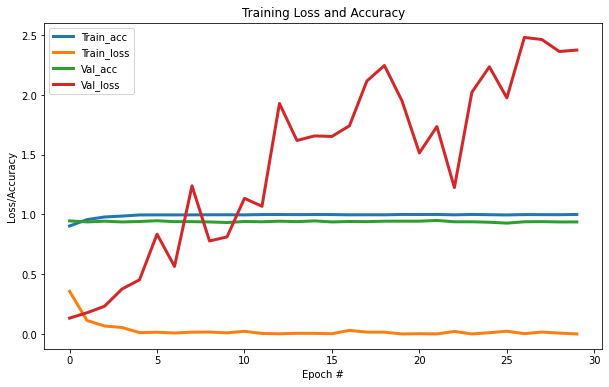

In [50]:
plotResults()

Let's try to predict the dog image as before!

This image is a dog.
With probability of  1.0


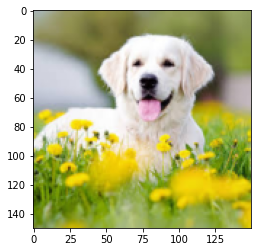

In [51]:
im = Image.open(r'./data/test/test.jpg') #dog test image
#im = Image.open(r'./data/test/dogcat.jpg') #dogcat test image
#im = Image.open(r'./data/validation/cats/cat.1000.jpg') #cats from validation set - can go through them

#open random image from validation dataset
#valsamplepath=glob.glob('./data/validation/*/*.jpg')
#import random
#randomint=random.randint(0,len(valsamplepath))
#im = Image.open(valsamplepath[randomint])

testimg = transform(im)
testimg=testimg[None,:].to(device) #trick to add one more dimension (batch dimension)

model_vgg.eval()
with torch.no_grad():
  pred_prob=torch.sigmoid(model_vgg(testimg))
  pred_class=(pred_prob > 0.5)

if pred_class == 1:
    prediction = 'dog'
    print("This image is a "+ prediction + ".")
    print('With probability of  ' + str(pred_prob.item()))
else:
    prediction = 'cat'
    print("This image is a "+ prediction + ".")
    print('With probability of  ' + str(1-pred_prob.item()))

plt.imshow(testimg.reshape(3,img_height,img_width).moveaxis(0,2).to('cpu'))
plt.show()

## Option 2: Design our own (simpler) classifier

We extract features from a pretrained model and feed them into our own separate classification model. 

### Define the classification model
Let's define our own simple classifier. Note that the input size must correspond to the vgg features output size (after avgpool and flatten).

In [52]:
class myvggclassifier(nn.Module):
    def __init__(self, nsize):
        super().__init__()
        #self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(nsize, 256)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)       
        self.fc2 = nn.Linear(256,1)

    def forward(self, x):
        x=self.dropout(self.relu(self.fc1(x)))
        x=self.fc2(x)

        return x #we use sigmoid in the 'train' loop, so no need to put here...

In [53]:
batch_size = 30

Let's initialise and train. This will be much faster than the previous classifier (simpler, less layers, less neurons!).

In [54]:
nsize = model_vgg.classifier[0].in_features
vgg_classifier = myvggclassifier(nsize).to(device)

optimizer = torch.optim.RMSprop(vgg_classifier.parameters(), lr=0.0001)
criterion = torch.nn.BCELoss()

In [55]:
ta=[]
va=[]
tl=[]
vl=[]
for epoch in range(30):
  train_acc, val_acc, train_loss, val_loss=train_vgg_classifier(vgg_classifier,train_feat_dataloader,val_feat_dataloader)
  ta.append(train_acc)
  va.append(val_acc)
  tl.append(train_loss)
  vl.append(val_loss)

| epoch   0 |    50/   67 batches | train_loss    0.305 | accuracy    0.885 | elapsed time   0.3 seconds
Validation-epoch 0. Avg-Val Loss: 0.1308, Val Accuracy: 0.9500,   Elapsed Time: 0.0
| epoch   1 |    50/   67 batches | train_loss    0.089 | accuracy    0.967 | elapsed time   0.3 seconds
Validation-epoch 1. Avg-Val Loss: 0.1520, Val Accuracy: 0.9387,   Elapsed Time: 0.0
| epoch   2 |    50/   67 batches | train_loss    0.056 | accuracy    0.977 | elapsed time   0.3 seconds
Validation-epoch 2. Avg-Val Loss: 0.1612, Val Accuracy: 0.9437,   Elapsed Time: 0.0
| epoch   3 |    50/   67 batches | train_loss    0.038 | accuracy    0.987 | elapsed time   0.3 seconds
Validation-epoch 3. Avg-Val Loss: 0.1716, Val Accuracy: 0.9463,   Elapsed Time: 0.0
| epoch   4 |    50/   67 batches | train_loss    0.026 | accuracy    0.992 | elapsed time   0.3 seconds
Validation-epoch 4. Avg-Val Loss: 0.2249, Val Accuracy: 0.9350,   Elapsed Time: 0.0
| epoch   5 |    50/   67 batches | train_loss    0.024

Excellent performance again. Showing that it's very beneficial to load feature representations from deep pretrained networks. 

Let's plot the performance over the training epochs.

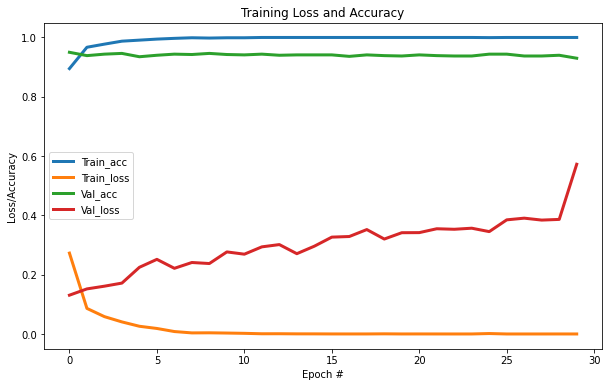

In [56]:
plotResults()

Let's connect our classifier with the vgg net - we will replace the original vgg 'classifier' part with our trained classifier.

In [57]:
original_classifier = model_vgg.classifier #we save the original/edited original classifier, just for the case we want to use it later
model_vgg.classifier = vgg_classifier # we replace the previous classifier with our simple one
print(model_vgg) # just to check it got replaced

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

### Predict new images (of any size)

Now we can classify images just like before, utilising our new classifier. Note that thanks to the AdaptiveAvgPool layer, vgg is able to take in images of various inputs. Let's try not to transform the size of our images, only convert them to tensors (so that PyTorch can operate with them).

The size of this input image is: torch.Size([1, 3, 333, 241])
This image is a dog.
With probability of  1.0


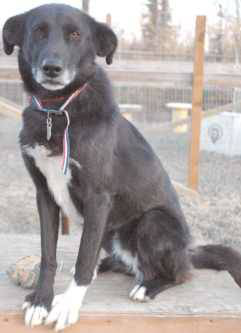

In [58]:
#im = Image.open(r'./data/test/test.jpg') #dog test image
#im = Image.open(r'./data/test/dogcat.jpg') #dogcat test image
#im = Image.open(r'./data/validation/cats/cat.1000.jpg') #cats from validation set - can go through them
transformToTens=transforms.ToTensor() # only transforming to tensors now, no resizing!
# open random image
import random
valsamplepath=glob.glob('./data/validation/*/*.jpg')
randomint=random.randint(0,len(valsamplepath))
im = Image.open(valsamplepath[randomint])

testimg = transformToTens(im)
testimg=testimg[None,:].to(device) #trick to add one more dimension (batch dimension)
print('The size of this input image is: ' + str(testimg.size()))

model_vgg.eval()
with torch.no_grad():
  pred_prob=torch.sigmoid(model_vgg(testimg))
  pred_class=(pred_prob > 0.5)

if pred_class == 1:
    prediction = 'dog'
    print("This image is a "+ prediction + ".")
    print('With probability of  ' + str(pred_prob.item()))
else:
    prediction = 'cat'
    print("This image is a "+ prediction + ".")
    print('With probability of  ' + str(1-pred_prob.item()))

im # we can show the original image, since that is what we are feeding the net right now!

# Look at unsuccessful predictions!

Sometimes it is useful to look at which predictions are wrong to get better understanding why. It might give you ideas on how to improve the model to get better results, e.g., when 2 cats are in the picture, but model thinks it's a dog. What if you could first detect the position of the two cats (as two unknown objects that look of interest) and then feed the model with the two cropped cats one by one. ;-)

In [59]:
# train_dataloader = DataLoader(train_dataset, batch_size=batch_size,shuffle=False,num_workers=2)
# we don't need the feature data loader here, because the evaluate function will route the input through the entire VGG network, which will automatically convert it into VGG features
val_dataloader = DataLoader(val_dataset, batch_size=batch_size,shuffle=False,num_workers=2)

accu,wrong = evaluate_vgg(model_vgg,val_dataloader) #evaluate the model, find the wrong predictions

In [60]:
wrong_index = torch.where(wrong==1) # get indeces of the wrong predictions
wrong_index = wrong_index[0]
wrong_index

tensor([ 61, 115, 161, 167, 195, 361, 398, 400, 412, 420, 432, 439, 443, 444,
        465, 469, 480, 487, 494, 510, 548, 551, 563, 565, 574, 593, 599, 601,
        603, 604, 608, 615, 626, 629, 646, 650, 659, 666, 688, 694, 698, 702,
        708, 711, 733, 746, 751, 763, 767, 769, 773, 774, 779, 781, 787, 788])

Now showing sample: 608
This image was classified as a cat with probability of 0.9888946246355772, but is a dog.


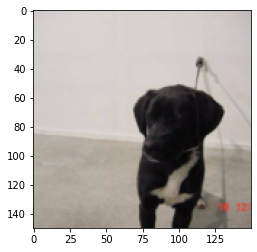

In [61]:
rs=random.randint(0,len(wrong_index)) # select random image from the wrong predictions set

print('Now showing sample: ' + str(wrong_index[rs].item()))

#testimg = transformToTens(im)

testimg,label = val_dataset[wrong_index[rs]]
testimg = testimg[None,:].to(device) #trick to add one more dimension (batch dimension)

model_vgg.eval()
with torch.no_grad():
  pred_prob=torch.sigmoid(model_vgg(testimg))
  pred_class=(pred_prob > 0.5)

if pred_class == 1:
    prediction = 'dog'
    print("This image was classified as a "+ prediction + ' with probability of ' + str(pred_prob.item()) + ", but it is a cat.")
else:
    prediction = 'cat'
    print("This image was classified as a "+ prediction + ' with probability of ' + str(1-pred_prob.item()) + ", but is a dog.")

plt.imshow(testimg.reshape(3,img_height,img_width).moveaxis(0,2).to('cpu'))
plt.show()

**Conclusion: we reached 90-95% accuracy on the validation set after ~20 epochs and using only 8% of the samples originally available on the Kaggle competition!**

##For further reading - transfer learning with finetuning

Using pretrained networks can really cause great improvements without the need of a big dataset or powerful GPU (because someone else has created it). If you do have the resources, you go even further improve upon pretrained networks, but not using them to just get features (embeddings), but to load the actual networks and their pretrained weights as part of your architecture, this allows you to further train (finetune) the weights tailored to your problem and should further improve the weights, but at the cost of having to train a deep network with much more weights. 

PyTorch has an excellent tutorial on transfer learning with finetuning: https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html

During training, you can choose the freeze the weights or let them be trainable (finetune). For instance for layer p1, this will freeze the weights: 

```
p1.weight.requires_grad = False
```

In sum, you load an existing model with pretrained weights, such as ResNet18, and then set if the weights require further training (grad). You can use the above function `.requires_grad` to adjust this per layer. 

```
model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224
```



## References
* https://www.analyticsvidhya.com/blog/2021/06/transfer-learning-using-vgg16-in-pytorch/
* https://www.kaggle.com/carloalbertobarbano/vgg16-transfer-learning-pytorch


# Exercise

Can you build a CNN based classifier for the following dataset? 

https://www.kaggle.com/alifrahman/chestxraydataset

*This dataset mainly consists of the chest X-ray images of Normal and Pneumonia affected patients. There are a total of 5840 chest X-ray images. It has two folders named train and test. Each of them has two sub-folders labeled as NORMAL and PNEUMONIA. This dataset can be used to detect pneumonia by training a convolutional neural network.*


What accuracy can you reach on the test set **for each class**? Please load the data and build a classifier that uses ResNet50 as a feature representation (either an approach like option 1 or 2 above but with ResNet not VGG). Include data augmentation in your data loader. 


Tip: to save the download/upload from kaggle, [you can just hit the new notebook button on the dataset page and run in on a kaggle kernel](https://www.kaggle.com/notebooks/welcome?datasetVersionId=1454699). Another option is to get an API key from kaggle so you can quickly load datasets in Colab: https://www.kaggle.com/general/74235

In [62]:
%matplotlib inline
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from torchsummary import summary
import torch.nn as nn
import torch
import torchvision.models as models
import time

In [63]:
import torch

print("PyTorch version:")
print(torch.__version__)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

PyTorch version:
1.10.0+cu111
Using cuda device


In [64]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download alifrahman/chestxraydataset

 99% 1.13G/1.14G [00:07<00:00, 152MB/s]
100% 1.14G/1.14G [00:07<00:00, 154MB/s]


In [65]:
# Unzip folder
! unzip chestxraydataset.zip


Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/IM-0419-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0420-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0421-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0423-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0424-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0425-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0427-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0428-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0429-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0429-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0429-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0430-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0431-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0432-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0433-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0434-0001.jpeg  
  inflating: chest_xray/tra

In [66]:
# Train-Val Split

import os
import numpy as np
import shutil

rootdir= 'chest_xray/train' #path of the original folder
classes = ['NORMAL', 'PNEUMONIA']

for i in classes:  
  os.makedirs(rootdir +'/train_dataset/' + i)
  os.makedirs(rootdir +'/val_dataset/' + i)
  source = rootdir + '/' + i +'/'

  allFileNames = os.listdir(source)
  np.random.shuffle(allFileNames)
  val_ratio = 0.25
  train_FileNames, val_FileNames = np.split(np.array(allFileNames),
                                                        [int(len(allFileNames)* (1 - val_ratio))])

  train_FileNames = [source+'/'+ name for name in train_FileNames.tolist()]
  val_FileNames = [source+'/' + name for name in val_FileNames.tolist()]

  for name in train_FileNames:
    shutil.copy(name, rootdir +'/train_dataset/' + i)

  for name in val_FileNames:
    shutil.copy(name, rootdir +'/val_dataset/' + i)

In [85]:
transform = transforms.Compose([transforms.Resize((300,300)),
                                transforms.RandomAffine(degrees=(-15,15),translate=(0.1,0.1),shear=(-7,7)),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor()])

transform_valtest = transforms.Compose([transforms.Resize((300,300)),
                                        transforms.ToTensor()])

# Load the training, validation and test dataset
train_dataset = datasets.ImageFolder('chest_xray/train/train_dataset', transform=transform)
val_dataset = datasets.ImageFolder('chest_xray/train/val_dataset', transform=transform_valtest)
test_dataset = datasets.ImageFolder('chest_xray/test', transform=transform_valtest)

In [86]:
batch_size=30

train_dataloader_forresnet50 = DataLoader(train_dataset, batch_size=batch_size,shuffle=False,num_workers=2)
val_dataloader_forresnet50 = DataLoader(val_dataset, batch_size=batch_size,shuffle=False,num_workers=2)
test_dataloader_forresnet50 = DataLoader(test_dataset, batch_size=1,shuffle=True,num_workers=2)

               NORMAL                NORMAL                NORMAL                NORMAL


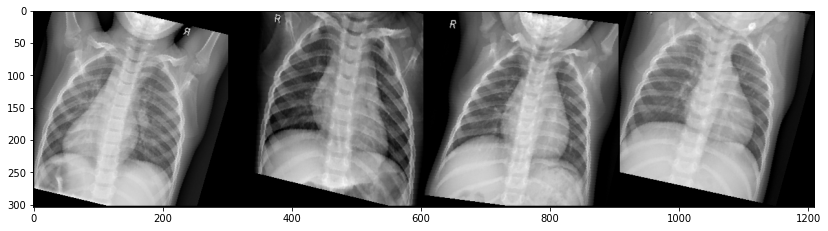

In [87]:
number_of_pics = 4
images,labels = next(iter(train_dataloader_forresnet50)) #load in a batch of data with the dataloader
imagegrid = torchvision.utils.make_grid(images[0:number_of_pics,:,:,:]) #join the images from the batch into one grid
print(' '.join('%21s' % classes[labels[j]] for j in range(number_of_pics)))
plt.figure(figsize=(14,14))
plt.imshow(imagegrid.moveaxis(0,2))
plt.show()

In [88]:
import torchvision.models as models
import torch.nn as nn

model_resnet50=models.resnet50(pretrained=True).to(device) #import the resnet50 model
print(model_resnet50) #Let's look at the model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [102]:
# we can freeze the weights by disabling gradient for the parameters, it should not be necessary in our case, since we do not plan to train the whole model, but FYI
for param in model_resnet50.parameters(): #disabling gradient in the 'features' part of the model (convolutional part)
    param.require_grad = False #tell the model to keep the weights fixed

num_features = model_resnet50.fc.in_features
features = list(model_resnet50.children())[:-1] # delete the last fc layer.

# # Newly created modules have require_grad=True by default
features.extend([nn.Linear(num_features, 1)]) # Add our layer with 1 output for binary classification
model_resnet50.classifier = nn.Sequential(*features).to(device) # Replace the final classification layer

print(model_resnet50)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [103]:
features_test = list(model_resnet50.children())[:-2] # Remove layer until AvgPool2d
new_model = nn.Sequential(*features_test).to(device) # Replace the final classification layer


In [104]:
def calcsize(model,channum,imh,imw):
  image=torch.rand(channum,imh,imw).to(device)
  image=image[None,:]
  output=model(image)
  return output.shape[1:]


channum=3 # number of colour channels - RGB=3

output_size=calcsize(new_model,channum,300,300)
print(output_size)

torch.Size([2048, 1, 1])


In [105]:
#defining a function that will run the data through the 'features' and 'avgpool' parts of the model
def gimmefeatures(model_resnet50,dataloader):
  model_resnet50.eval()
  output=torch.zeros((len(dataloader.dataset),2048,1,1))
  label=torch.zeros((len(dataloader.dataset)))
  i=0

  with torch.no_grad():
    for j, data in enumerate(dataloader):
        inputs, labels = data
        inputs=inputs.to(device)
        layer0 = model_resnet50.maxpool(model_resnet50.relu(model_resnet50.bn1(model_resnet50.conv1(inputs))))
        layer1 = model_resnet50.layer1(layer0)
        layer2 = model_resnet50.layer2(layer1)
        layer3 = model_resnet50.layer3(layer2)
        layer4 = model_resnet50.layer4(layer3)
        outputs = model_resnet50.avgpool(layer4)
        output[i:i+outputs.shape[0],:,:,:]=outputs
        label[i:i+labels.shape[0]]=labels
        i=i+outputs.shape[0]
        print(i)

  return output, label

In [106]:
train_feats, train_labels=gimmefeatures(model_resnet50,train_dataloader_forresnet50)

# move this to GPU
train_feats=train_feats.to(device)
train_labels=train_labels.to(device)

torch.save((train_feats,train_labels),'train_data_resnet50.pt')

30
60
90
120
150
180
210
240
270
300
330
360
390
420
450
480
510
540
570
600
630
660
690
720
750
780
810
840
870
900
930
960
990
1020
1050
1080
1110
1140
1170
1200
1230
1260
1290
1320
1350
1380
1410
1440
1470
1500
1530
1560
1590
1620
1650
1680
1710
1740
1770
1800
1830
1860
1890
1920
1950
1980
2010
2040
2070
2100
2130
2160
2190
2220
2250
2280
2310
2340
2370
2400
2430
2460
2490
2520
2550
2580
2610
2640
2670
2700
2730
2760
2790
2820
2850
2880
2910
2940
2970
3000
3030
3060
3090
3120
3150
3180
3210
3240
3270
3300
3330
3360
3390
3420
3450
3480
3510
3540
3570
3600
3630
3660
3690
3720
3750
3780
3810
3840
3870
3900
3911


In [107]:
# same for validation data
val_feats, val_labels=gimmefeatures(model_resnet50,val_dataloader_forresnet50)

val_feats=val_feats.to(device)
val_labels=val_labels.to(device)

torch.save((val_feats,val_labels),'val_data_resnet50.pt')

30
60
90
120
150
180
210
240
270
300
330
360
390
420
450
480
510
540
570
600
630
660
690
720
750
780
810
840
870
900
930
960
990
1020
1050
1080
1110
1140
1170
1200
1230
1260
1290
1305


In [114]:
train_feats,train_labels=torch.load('train_data_resnet50.pt')
val_feats,val_labels=torch.load('val_data_resnet50.pt')

In [115]:
train_feat_dataset_resnet50 = torch.utils.data.TensorDataset(train_feats,train_labels)
train_feat_dataloader_resnet50 = DataLoader(train_feat_dataset_resnet50,batch_size=30,shuffle=True,num_workers=0)

val_feat_dataset_resnet50 = torch.utils.data.TensorDataset(val_feats,val_labels)
val_feat_dataloader_resnet50 = DataLoader(val_feat_dataset_resnet50,batch_size=30,shuffle=True,num_workers=0)

In [116]:
#check that it works - we should be getting two tensors - features, and labels of sizes [batch_size,512,7,7] and [batch_size]
feata,laba=next(iter(train_feat_dataloader_resnet50))
print(feata.shape)
print(laba.shape)

torch.Size([30, 2048, 1, 1])
torch.Size([30])


In [117]:
def train_resnet50_classifier(modelclassifier,dataloader,val_dataloader):
    modelclassifier.train() #set the mode of the model to train mode
    total_acc, total_count, rep_acc, rep_count = 0, 0, 0, 0
    train_loss, rep_loss=0.0, 0.0
    log_interval = 50
    start_time = time.time()

    for i, data in enumerate(dataloader):
        inputs, labels = data
        labels=labels.reshape(labels.shape[0],1).float().to(device)
        inputs=inputs.to(device)
        labels=labels.to(device)

        optimizer.zero_grad()
        # forward propagation
        predicted_label = torch.sigmoid(modelclassifier(torch.flatten(inputs,start_dim=1)))

        # calculate loss and backpropagate to model paramters
        loss = criterion(predicted_label, labels)
        train_loss += loss.item() # to be reported per epoch
        rep_loss += loss.item() # to be reported per log_interval batches
        loss.backward()
        torch.nn.utils.clip_grad_norm_(modelclassifier.parameters(), 0.1)
        # update parameters by stepping the optimizer
        optimizer.step()
        total_acc += ((predicted_label > 0.5) == labels).sum().item() # to be reported per epoch
        rep_acc += ((predicted_label > 0.5) == labels).sum().item() # to be reported per log_interval batches
        total_count += labels.size(0)
        rep_count += labels.size(0)

        if i % log_interval == 0 and i > 0:
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches '
                  '| train_loss {:8.3f} | accuracy {:8.3f} | elapsed time {:5.1f} seconds'.format(epoch, i, len(dataloader),
                                              rep_loss/log_interval, rep_acc/rep_count, elapsed))
            rep_acc, rep_count = 0, 0
            rep_loss=0.0
            start_time = time.time()


          # Make a pass over the validation data.
    val_acc, val_count = 0.0, 0.0
    cum_loss = 0.0
    start_time = time.time()
    modelclassifier.eval()

    with torch.no_grad():
        for j, data in enumerate(val_dataloader):
            inputs, labels = data
            labels=labels.reshape(labels.shape[0],1).float().to(device)
            inputs=inputs.to(device)

            # Forward pass. (Prediction stage)
            scores = torch.sigmoid(modelclassifier(torch.flatten(inputs,start_dim=1)))
            cum_loss += criterion(scores, labels).item()

            # Count how many correct in this batch.
            val_acc += ((scores > 0.5) == labels).sum().item()
            val_count += labels.size(0)

    elapsed = time.time() - start_time
    # Logging the current results on validation.
    print('Validation-epoch %d. Avg-Val Loss: %.4f, Val Accuracy: %.4f,   Elapsed Time: %.1f' % 
            (epoch, cum_loss / (j + 1), val_acc/val_count,elapsed))
    return total_acc/total_count, val_acc/val_count, train_loss/(i+1), cum_loss / (j + 1)

In [118]:
optimizer = torch.optim.RMSprop(model_resnet50.fc.parameters(), lr=0.0001)
criterion = torch.nn.BCELoss()

In [120]:
ta=[]
va=[]
tl=[]
vl=[]

max_val_acc = 0
stop_trigger = 0
patience = 10

for epoch in range(100):
  train_acc, val_acc, train_loss, val_loss=train_resnet50_classifier(model_resnet50.fc,train_feat_dataloader_resnet50,val_feat_dataloader_resnet50)
  ta.append(train_acc)
  va.append(val_acc)
  tl.append(train_loss)
  vl.append(val_loss)
  if (val_acc >= max_val_acc):
      max_val_acc = val_acc
      stop_trigger = 0 # Reset count
    
  elif (val_acc < max_val_acc):
    stop_trigger += 1 
    print("Triggered! --> ", stop_trigger , "/", patience)

  if stop_trigger == patience:
      print("Early stopped!!!")
      break
  print("Max Validation Accuracy: ", max_val_acc)

| epoch   0 |    50/  131 batches | train_loss    0.488 | accuracy    0.752 | elapsed time   0.1 seconds
| epoch   0 |   100/  131 batches | train_loss    0.387 | accuracy    0.829 | elapsed time   0.1 seconds
Validation-epoch 0. Avg-Val Loss: 0.3406, Val Accuracy: 0.9065,   Elapsed Time: 0.0
Max Validation Accuracy:  0.9065134099616858
| epoch   1 |    50/  131 batches | train_loss    0.328 | accuracy    0.876 | elapsed time   0.1 seconds
| epoch   1 |   100/  131 batches | train_loss    0.307 | accuracy    0.883 | elapsed time   0.1 seconds
Validation-epoch 1. Avg-Val Loss: 0.2995, Val Accuracy: 0.8981,   Elapsed Time: 0.0
Triggered! -->  1 / 10
Max Validation Accuracy:  0.9065134099616858
| epoch   2 |    50/  131 batches | train_loss    0.279 | accuracy    0.898 | elapsed time   0.2 seconds
| epoch   2 |   100/  131 batches | train_loss    0.256 | accuracy    0.907 | elapsed time   0.1 seconds
Validation-epoch 2. Avg-Val Loss: 0.2718, Val Accuracy: 0.9011,   Elapsed Time: 0.0
Trigg

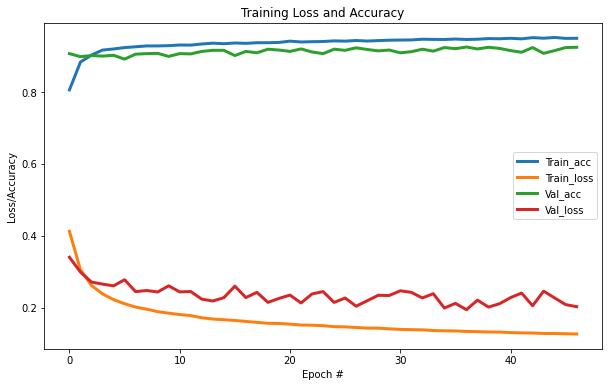

In [121]:
plotResults()

In [122]:
def evaluate_resnet50(model,dataloader):
    model.eval()
    total_acc, total_count = 0, 0
    wrong=torch.zeros((len(dataloader.dataset)),1)
    class0_acc, class0_count = 0, 0 # Normal
    class1_acc, class1_count = 0, 0 # Pneumonia

    j=0
    with torch.no_grad():
        for i, data in enumerate(dataloader):
            inputs, labels = data
            inputs=inputs.to(device)
            labels=labels.reshape(labels.shape[0],1).float().to(device)
            predicted_label = torch.sigmoid(model(inputs))
            correct=((predicted_label > 0.5) == labels)
            total_acc += correct.sum().item()
            total_count += labels.size(0)
            wrong[j:j+labels.size(0),:]=~correct
            j=j+labels.size(0)
            
            if labels == 0: # If it is normal
              class0_acc += correct.sum().item()
              class0_count += labels.size(0)

            else: # If it is pneumonia
              class1_acc += correct.sum().item()
              class1_count += labels.size(0)

        total_accuracy = total_acc/total_count
        class0_accuracy = class0_acc/class0_count
        class1_accuracy = class1_acc/class1_count
            
    return total_accuracy, class0_accuracy, class1_accuracy

In [123]:
total_accuracy, class0_accuracy, class1_accuracy = evaluate_resnet50(model_resnet50,test_dataloader_forresnet50)
 
print(f"Accuracy for 'NORMAL' class: {class0_accuracy}")
print(f"Accuracy for 'PNEUMONIA' class: {class1_accuracy}")
print(f"Total Accuracy: {total_accuracy}")

Accuracy for 'NORMAL' class: 0.6367521367521367
Accuracy for 'PNEUMONIA' class: 0.9256410256410257
Total Accuracy: 0.8173076923076923
